#Import libraries

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple
from torch.utils.data import Dataset
from torch.autograd import Variable

# Downloading, Loading and Normalising CIFAR-10

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=50,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:02, 73756926.32it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Utility functions

In [0]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
is_cuda = torch.cuda.is_available()
is_cuda

True

In [0]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    for e in range(epoch):
      if is_cuda:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        model = model.cuda()
      if phase == 'training':
          model.train()
      if phase == 'validation':
          model.eval()
          # volatile=True
      running_loss = 0.0
      running_correct = 0
      for batch_idx , (data,target) in enumerate(data_loader):
          if is_cuda:
              data,target = data.cuda(),target.cuda()
          # data , target = Variable(data,volatile),Variable(target)
          if phase == 'training':
              optimizer.zero_grad()
          output = model(data)
          loss = criterion(output,target)
          
          running_loss += F.cross_entropy(output,target,size_average=False).data
          preds = output.data.max(dim=1,keepdim=True)[1]
          running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
          if phase == 'training':
              loss.backward()
              optimizer.step()
      
      loss = running_loss/len(data_loader.dataset)
      accuracy = 100. * running_correct.item()/len(data_loader.dataset)
      
      print(f'epoch : {e+1} :{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy


# Creating Inception V1 model

## define Inception

In [0]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


## Define GoogleNet

In [0]:
'''GoogLeNet with PyTorch.'''
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

net = GoogLeNet()

# Training model

In [0]:
fit(10,net,trainloader)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch : 1 :training loss is   1.3 and training accuracy is 25780/50000     51.56
epoch : 2 :training loss is  0.85 and training accuracy is 35001/50000      70.0
epoch : 3 :training loss is  0.64 and training accuracy is 38971/50000     77.94
epoch : 4 :training loss is  0.49 and training accuracy is 41424/50000     82.85
epoch : 5 :training loss is  0.39 and training accuracy is 43239/50000     86.48
epoch : 6 :training loss is  0.31 and training accuracy is 44723/50000     89.45
epoch : 7 :training loss is  0.24 and training accuracy is 45852/50000      91.7
epoch : 8 :training loss is  0.19 and training accuracy is 46786/50000     93.57
epoch : 9 :training loss is  0.15 and training accuracy is 47487/50000     94.97
epoch : 10 :training loss is  0.11 and training accuracy is 48195/50000     96.39


(tensor(0.1108, device='cuda:0'), 96.39)

# Testing network

In [0]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels =  images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 83.55%


In [0]:
print('{0:10s} - Accuarcy'.format('Category'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuarcy
plane      - 84.8
car        - 93.6
bird       - 77.8
cat        - 73.4
deer       - 80.5
dog        - 76.5
frog       - 81.2
horse      - 88.4
ship       - 91.6
truck      - 87.7


Finally, let us visualise the confusion matrix to determine common misclassifications.

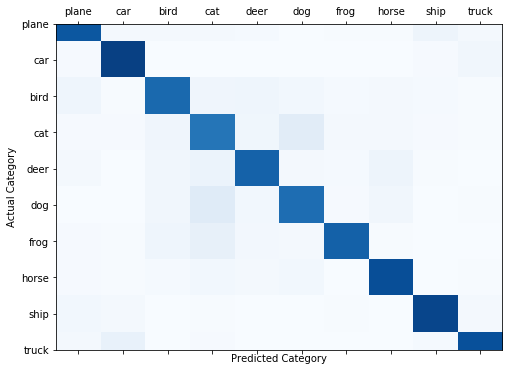

In [0]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

From the above visualisation we can see that the best accuracy was achieved on the **`car`** and **`ship`** categories, darkest shades present on the main diagonal. The **`truck`** category was most frequently confused with the **`car`** category. This is understandable, since they are both vehicles and have some visual similarities. **`Planes`** were also commonly confused with **`bird`** and **`ship`**. This could have something to do with a common background texture and colour, blue for both sky and sea. **`cat`** were also commonly confused with **`dog`** and **`frog`**.

To understand precisely which categories were most commonly confused, we can print the absolute and relative values of the confusion matrix, as follows.

In [0]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           848       20        18        19        14        3         5         7         50        16        
                0.848     0.02      0.018     0.019     0.014     0.003     0.005     0.007     0.05      0.016     
car             11        936       0         3         0         2         3         2         11        32        
                0.011     0.936     0.0       0.003     0.0       0.002     0.003     0.002     0.011     0.032     
bird            45        7         778       40        43        31        15        23        12        6         
                0.045     0.007     0.778     0.04      0.043     0.031     0.015     0.023     0.012     0.006     
cat             11        8         41        734       39        110       19        23        9         6         
                0.011     0.008     0.041     0.734     0.039   